In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.9":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.9":
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.21.1", 'matplotlib': "3.4.2",'sklearn': "0.24.2", 
                'pandas': "1.3.1",'xgboost': "1.3.3", 'shap': "0.39.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.9.7 | packaged by conda-forge | (default, Sep  2 2021, 17:55:20) [MSC v.1916 64 bit (AMD64)]

[ OK ] numpy version 1.21.1 is installed.
[ OK ] matplotlib version 3.4.2 is installed.
[ OK ] sklearn version 0.24.2 is installed.
[ OK ] pandas version 1.3.1 is installed.
[ OK ] xgboost version 1.3.3 is installed.
[ OK ] shap version 0.39.0 is installed.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pylab as plt
%pylab inline
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from  sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy


In [3]:
fontsize=14
rcParams['font.size']=fontsize
rcParams['font.family']='sans-serif'
rcParams['axes.labelsize']=fontsize
rcParams['axes.titlesize']=fontsize
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=fontsize
rcParams['legend.fontsize']=fontsize
rcParams['figure.figsize']=(10,7.5)
rcParams['axes.grid']=True

In [4]:
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('data/train_V2.csv')
df.sample(10)

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.shape

In [ ]:
match_df = df.groupby('matchId').count()['Id']

In [ ]:
fig = plt.figure()
plt.violinplot(match_df)
plt.ylabel('number of players')
plt.xlabel('match')
plt.title('Number of Players in Each Match')
plt.show()
fig.savefig('figures/Number of Players in Each Match.jpg', dpi = 300)

In [ ]:
fig,ax = plt.subplots(figsize=(16,12))
ax = sns.heatmap(df.corr(), annot=True)
fig.savefig('figures/Correlation.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
df['winPlacePerc'].plot.hist(bins=100)
plt.xlabel('win place percentage')
plt.ylabel('count')
plt.title('Distribution of Win Place')
plt.show()
fig.savefig('figures/Distribution of Win Place.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
df.plot.scatter('killPlace','winPlacePerc',s=1,alpha=0.1)
plt.ylabel('win place percentage')
plt.xlabel('kill place')
plt.title('Distribution of Win Place vs. Kill Place')
plt.show()
fig.savefig('figures/Distribution of Win Place vs. Kill Place.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
df['walkDistance'].plot.hist(bins=50, log=True)
plt.xlabel('walk distance')
plt.ylabel('count')
plt.title('Distribution of Walk Distance')
plt.show()
fig.savefig('figures/Distribution of Walk Distance.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
df['kills'].plot.hist(bins=df['kills'].nunique(), log=True)
plt.xlabel('kills')
plt.ylabel('count')
plt.title('Distribution of Kills')
plt.show()
fig.savefig('figures/Distribution of Kills.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
df[['winPlacePerc','matchType']].boxplot(by='matchType',figsize=(22,16.5))
plt.ylabel('win place percentage')
plt.xlabel('match type')
plt.title('Distribution of Win Place')
plt.show()
fig.savefig('figures/Distribution of Win Place by Match Type.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
pd.value_counts(df['matchType'],normalize=True).plot.bar()
plt.ylabel('fraction')
plt.xlabel('match type')
plt.title('Distribution of Match Type')
plt.show()
fig.savefig('figures/Distribution of Match Type.jpg', dpi = 300)

In [ ]:
fig = plt.figure()
pd.plotting.scatter_matrix(df[['assists', 'boosts', 'killPlace', 'kills', 'winPlacePerc']], marker='o', s=1, alpha=0.1)
plt.show()
fig.savefig('figures/Scatter Matrix.jpg', dpi = 300)

In [ ]:
n = len(pd.unique(df['Id']))
n

In [ ]:
column_list = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 
               'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace', 'revives', 'rideDistance', 
               'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 
               'winPlacePerc']

In [ ]:
ndf = df[column_list]
ndf.sample(10)

In [ ]:
ndf.shape

In [ ]:
sdf = ndf.sample(round(0.01*len(ndf)), random_state=11)
sdf.to_csv('data/sample.csv')

In [5]:
sdf = pd.read_csv('data/sample.csv')
sdf.head()

,Unnamed: 0,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,2069048,0,0,57.33,0,0,0,82,0,0,0,0.00,1382,squad,27,0,0.0,0,0.0,0,0,199.2,2,0,0.1538
1,25967,3,5,217.10,1,0,2,22,1231,1,1,141.80,2091,squad,26,0,2405.0,0,0.0,0,1,3711.0,5,1530,0.9200
2,2896533,0,0,242.70,0,0,0,63,0,0,0,0.00,1361,squad-fpp,28,0,0.0,0,0.0,0,0,593.8,2,0,0.3704
3,3314281,0,0,100.00,1,0,0,31,0,1,1,13.73,1387,duo-fpp,48,0,0.0,0,11.3,0,0,1150.0,3,0,0.7234
4,2707511,0,0,63.21,0,0,0,81,0,0,0,0.00,1800,duo-fpp,49,0,0.0,0,0.0,0,0,94.5,2,0,0.1667


In [6]:
nsdf = sdf.loc[:, sdf.columns != 'Unnamed: 0']
nsdf.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,57.33,0,0,0,82,0,0,0,0.00,1382,squad,27,0,0.0,0,0.0,0,0,199.2,2,0,0.1538
1,3,5,217.10,1,0,2,22,1231,1,1,141.80,2091,squad,26,0,2405.0,0,0.0,0,1,3711.0,5,1530,0.9200
2,0,0,242.70,0,0,0,63,0,0,0,0.00,1361,squad-fpp,28,0,0.0,0,0.0,0,0,593.8,2,0,0.3704
3,0,0,100.00,1,0,0,31,0,1,1,13.73,1387,duo-fpp,48,0,0.0,0,11.3,0,0,1150.0,3,0,0.7234
4,0,0,63.21,0,0,0,81,0,0,0,0.00,1800,duo-fpp,49,0,0.0,0,0.0,0,0,94.5,2,0,0.1667


In [7]:
len(nsdf)

44470

In [8]:
X = nsdf.loc[:, nsdf.columns != 'winPlacePerc']
y = nsdf['winPlacePerc']

onehot_ftrs = ['matchType']
minmax_ftrs = ['killPlace', 'maxPlace']
std_ftrs = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPoints', 'kills', 'killStreaks', 
            'longestKill', 'matchDuration', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 
            'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

prep = Pipeline(steps=[('preprocessor', preprocessor)])

In [9]:
X = nsdf.loc[:, nsdf.columns != 'winPlacePerc']
X_prep = prep.fit_transform(X)
y = nsdf['winPlacePerc']

In [10]:
model = RandomForestRegressor(n_estimators=600,max_depth=14,random_state=11).fit(X_prep, y)
r = permutation_importance(model, X_prep, y, n_repeats=20, random_state=11, scoring='neg_mean_absolute_error')

In [11]:
r.importances_mean

array([1.21624537e-05, 1.23919707e-06, 2.15723794e-04, 5.89398710e-04,
       1.76309496e-07, 4.50115053e-06, 5.89523548e-05, 1.79334383e-08,
       8.06334997e-06, 9.19670157e-06, 7.75525129e-05, 2.71437029e-04,
       3.98086598e-04, 7.15075543e-04, 1.24454505e-03, 2.14093281e-01,
       2.18071660e-02, 1.10121438e-03, 4.97540828e-03, 4.35465645e-03,
       2.83824979e-03, 2.64202740e-04, 1.84541177e-03, 1.45425963e-03,
       1.82366162e-02, 1.23753989e-02, 7.86746122e-03, 2.02202387e-02,
       3.19326002e-04, 5.80150974e-03, 1.64437787e-05, 2.88058604e-04,
       8.19267765e-05, 2.40443301e-05, 1.19005545e-01, 3.25551466e-03,
       1.59871968e-03])

In [12]:
r.importances_std

array([5.69656654e-07, 4.18013099e-08, 6.45038507e-06, 1.40484953e-05,
       1.83183870e-08, 4.73854742e-07, 2.10107999e-06, 0.00000000e+00,
       8.91345260e-07, 1.42473532e-07, 4.66727431e-06, 1.05089998e-05,
       2.93016925e-05, 1.40612609e-05, 2.71053178e-05, 1.01611269e-03,
       1.36841626e-04, 1.98520094e-05, 5.40499354e-05, 3.25117108e-05,
       4.12408575e-05, 4.34047396e-06, 2.73052266e-05, 1.43345365e-05,
       1.71780145e-04, 1.49167268e-04, 6.80278840e-05, 2.09177333e-04,
       5.39736319e-06, 6.85292403e-05, 8.18288808e-07, 4.34182729e-06,
       4.63931115e-06, 2.36831974e-06, 5.78586370e-04, 5.66925077e-05,
       1.86634001e-05])

In [16]:
features = list(prep.named_steps['preprocessor'].transformers_[0][1].get_feature_names(onehot_ftrs))+minmax_ftrs+std_ftrs
len(features)

37

In [18]:
pi_df = pd.DataFrame(list(zip(features, r.importances_mean, r.importances_std)), columns = ['feature', 'mean', 'std'])
pi_df.sort_values(by=['mean'], ascending=False, inplace=True)

In [23]:
pi_df

,feature,mean,std
15,killPlace,2.140933e-01,1.016113e-03
34,walkDistance,1.190055e-01,5.785864e-04
16,maxPlace,2.180717e-02,1.368416e-04
27,matchDuration,2.022024e-02,2.091773e-04
24,kills,1.823662e-02,1.717801e-04
25,killStreaks,1.237540e-02,1.491673e-04
26,longestKill,7.867461e-03,6.802788e-05
29,rideDistance,5.801510e-03,6.852924e-05
18,boosts,4.975408e-03,5.404994e-05
19,damageDealt,4.354656e-03,3.251171e-05


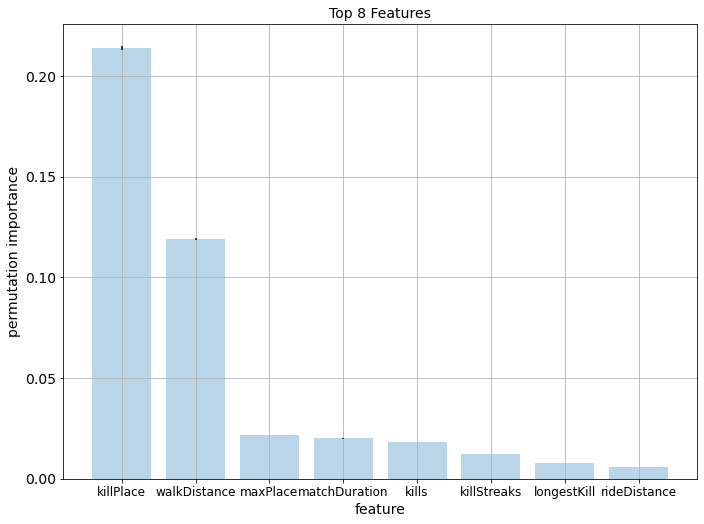

In [22]:
x_pos = np.arange(8)
fig, ax = plt.subplots()
ax.bar(x_pos, pi_df['mean'][:8], yerr=pi_df['std'][:8], align='center', alpha=0.3)
ax.set_ylabel('permutation importance')
ax.set_xlabel('feature')
ax.set_xticks(x_pos)
ax.set_xticklabels(pi_df['feature'][:8])
ax.set_title('Top 8 Features')
plt.tight_layout()
plt.show()
fig.savefig('figures/Top 8 Features (permutation importance).jpg', dpi = 300)

In [31]:
fi_df = pd.DataFrame(features, columns=['feature'])
nr_states = 20

for i in range(nr_states):
    clf = RandomForestRegressor(n_estimators=600,max_depth=14,random_state=17*i).fit(X_prep, y)
    fi_df[str(i)] = clf.feature_importances_
    print(i, 'done!')

0 done!
1 done!
2 done!
3 done!
4 done!
5 done!
6 done!
7 done!
8 done!
9 done!
10 done!
11 done!
12 done!
13 done!
14 done!
15 done!
16 done!
17 done!
18 done!
19 done!


In [45]:
fi_df['mean'] = list(fi_df.set_index('feature').mean(axis=1))
fi_df['std'] = list(fi_df.set_index('feature').std(axis=1))

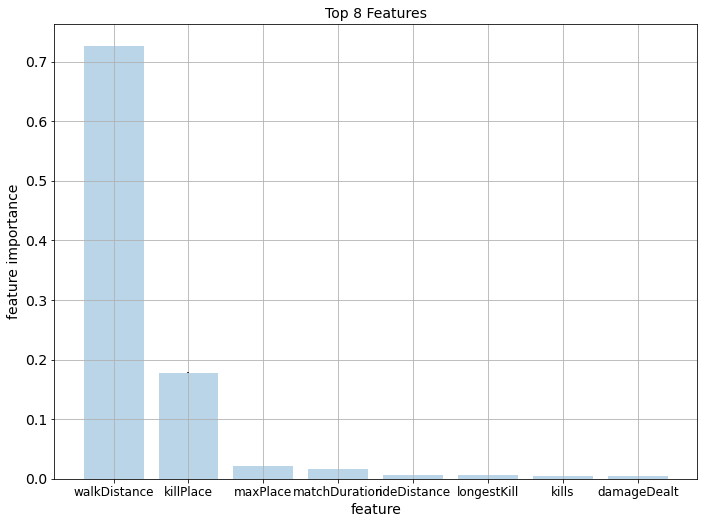

In [48]:
fi_df.sort_values(by=['mean'], ascending=False, inplace=True)
x_pos = np.arange(8)
fig, ax = plt.subplots()
ax.bar(x_pos, fi_df['mean'][:8], yerr=fi_df['std'][:8], align='center', alpha=0.3)
ax.set_ylabel('feature importance')
ax.set_xlabel('feature')
ax.set_xticks(x_pos)
ax.set_xticklabels(fi_df['feature'][:8])
ax.set_title('Top 8 Features')
plt.tight_layout()
plt.show()
fig.savefig('figures/Top 8 Features (feature importance).jpg', dpi = 300)